In [ ]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%time
!git clone https://github.com/WongKinYiu/PyTorch_YOLOv4.git  # clone repo
#!pip install -r pytorch-YOLOv4/requirements.txt  # install dependencies
#!cp pytorch-YOLOv4/requirements.txt ./

!pip install numpy>=1.18.2
#!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.6.0 torchvision==0.7.0 #torch 1.7.0
!pip install tensorboardX>=2.0
!pip install scikit_image>=0.16.2
!pip install matplotlib>=2.2.3
!pip install tqdm>=4.43.0
!pip install easydict>=1.9
!pip install Pillow>=7.1.2
!pip install --user opencv_python
!pip install pycocotools


Cloning into 'PyTorch_YOLOv4'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 651 (delta 0), reused 1 (delta 0), pack-reused 648
Receiving objects: 100% (651/651), 1.28 MiB | 2.93 MiB/s, done.
Resolving deltas: 100% (353/353), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 748.8 MB 21 kB/s 
     |████████████████████████████████| 5.9 MB 70.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages tha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 2.22 s, sys: 451 ms, total: 2.67 s
Wall time: 2min 7s


In [ ]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [ ]:
# just sample one to see
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car-object-detection/data/training_images/{image}.jpg')
#img.shape

Image ID: vid_4_3200


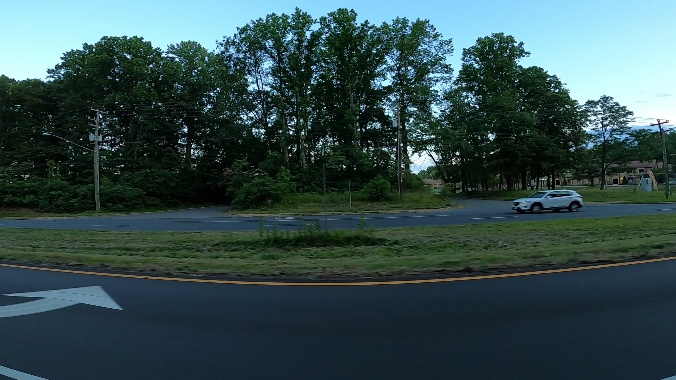

In [ ]:
index = list(set(df.image_id))
image = random.choice(index)
Image(filename=f'/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car-object-detection/data/training_images/{image}.jpg',width=600)

In [ ]:
#Training
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/content/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/content/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car-object-detection/data/{}/{}.jpg".format(source,name),'/content/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))


  0%|          | 0/355 [00:00<?, ?it/s]

In [ ]:
###car.yaml example: (not run)

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
#path: ../datasets/coco128  # dataset root dir
#train: images/train2017  # train images (relative to 'path') 128 images
#val: images/train2017  # val images (relative to 'path') 128 images
#test:  # test images (optional)

# Classes
nc: 80  # number of classes
names: [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]  # class names

In [ ]:
# running the training procedure
#Its recommended to use the cpu, but if you are using the gpu of google colabs, you need to configure some settings:
#Go to /usr/local/lib/python3.8/dist-packages/torch/tensor.py and at line 480 change the code from:
#return self.numpy() to self.cuda().numpy()
import torchvision
#Tensor.to(cuda)
!python /content/PyTorch_YOLOv4/train.py --batch 4 --epochs 2 --data /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car.yaml --cfg /content/PyTorch_YOLOv4/cfg/yolov4-pacsp.cfg
# once the training is done, your weights will be stored in 'PyTorch_YOLOv4/runs/train/exp/weights/' (googlecolab page on the left)

Using torch 1.6.0 CUDA:0 (Tesla T4, 15109MB)

Namespace(adam=False, batch_size=4, bucket='', cache_images=False, cfg='/content/PyTorch_YOLOv4/cfg/yolov4-pacsp.cfg', data='/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car.yaml', device='', epochs=2, evolve=False, exist_ok=False, global_rank=-1, hyp='./PyTorch_YOLOv4/data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp2', single_cls=False, sync_bn=False, total_batch_size=4, weights='yolov4.weights', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
NumExpr defaulting to 2 threads.
Hyperparameters {'lr0': 0.01, 'lrf': 0.1, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.3, 'cls_pw': 1.

In [ ]:
#You can change the video here as you like and compare it with other mp4 datas
!python PyTorch_YOLOv4/detect.py --name /content/PyTorch_YOLOv4/data/coco.names --cfg /content/PyTorch_YOLOv4/cfg/yolov4-pacsp.cfg --weights /content/runs/train/exp/weights/best.pt --conf 0.3 --source /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4
# "yolo" RuntimeError: Given groups=1, weight of size expected input -> train.py https://blog.csdn.net/qq_43533724/article/details/121743384

Namespace(agnostic_nms=False, augment=False, cfg='/content/PyTorch_YOLOv4/cfg/yolov4-pacsp.cfg', classes=None, conf_thres=0.3, device='', img_size=640, iou_thres=0.5, names='/content/PyTorch_YOLOv4/data/coco.names', output='inference/output', save_txt=False, source='/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4', update=False, view_img=False, weights=['/content/runs/train/exp/weights/best.pt'])
video 1/1 (1/764) /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4: 512x640 Done. (0.029s)
video 1/1 (2/764) /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4: 512x640 Done. (0.029s)
video 1/1 (3/764) /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4: 512x640 Done. (0.026s)
video 1/1 (4/764) /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4: 512x640 Done. (0.026s)
video 1/1 (5/764) /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Ca

In [ ]:
# not a must to run here, you can download the processed video/image from 'PyTorch_YOLOv4/inference/output'
# below is just a display code for mp4 on googlecolab
#Takes a long time to process video here
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

video_path = "/content/inference/output/Police_Car.mp4"
show_video(video_path)

Output hidden; open in https://colab.research.google.com to view.